<a href="https://colab.research.google.com/github/yagoojoy/PINN_Taylor-Green-Vortex/blob/main/260113_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 0. 환경 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# 1. 데이터 생성 클래스 (동일)
class FluidGenerator:
    def __init__(self, L=4.0, nu=0.01):
        self.L, self.nu = L, nu
    def get_tgv_solution(self, X, Y, t):
        k = 1
        decay = np.exp(-2 * (k * np.pi)**2 * self.nu * t)
        u = -1.0 * np.cos(k * np.pi * X) * np.sin(k * np.pi * Y) * decay
        v =  1.0 * np.sin(k * np.pi * X) * np.cos(k * np.pi * Y) * decay
        p = -0.25 * (np.cos(2 * k * np.pi * X) + np.cos(2 * k * np.pi * Y)) * np.exp(-4 * (k * np.pi)**2 * self.nu * t)
        return u, v, p
    def get_unphysical_noise(self, X, Y, t):
        noise_scale = 0.05 * np.exp(-0.1 * t) # 노이즈 강도 소폭 조절
        u_n = noise_scale * np.sin(8 * np.pi * X / self.L) * np.sin(8 * np.pi * Y / self.L)
        v_n = noise_scale * np.cos(8 * np.pi * X / self.L) * np.cos(8 * np.pi * Y / self.L)
        p_n = noise_scale * 0.5 * (np.sin(4 * np.pi * X / self.L))
        return u_n, v_n, p_n
    def get_data_at_t(self, nx, ny, t_val):
        x, y = np.linspace(0, self.L, nx), np.linspace(0, self.L, ny)
        X, Y = np.meshgrid(x, y)
        u_hf, v_hf, p_hf = self.get_tgv_solution(X, Y, t_val)
        u_n, v_n, p_n = self.get_unphysical_noise(X, Y, t_val)
        return X, Y, u_hf + u_n, v_hf + v_n, p_hf + p_n, u_hf, v_hf, p_hf

# 2. 데이터셋 구성 (시간 정규화 추가)
L_val, nu_val, GRID = 4.0, 0.01, 100
T_max = 10.0
generator = FluidGenerator(L=L_val, nu=nu_val)
train_times = np.linspace(0, T_max, 11)

x_list, y_list, t_list, u_lf_list, v_lf_list, p_lf_list = [], [], [], [], [], []
for t in train_times:
    X, Y, u_l, v_l, p_l, _, _, _ = generator.get_data_at_t(GRID, GRID, t)
    x_list.append(X.flatten()); y_list.append(Y.flatten()); t_list.append(np.full(X.size, t))
    u_lf_list.append(u_l.flatten()); v_lf_list.append(v_l.flatten()); p_lf_list.append(p_l.flatten())

x_train = torch.tensor(np.concatenate(x_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(np.concatenate(y_list)/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(np.concatenate(t_list)/T_max, dtype=torch.float32).view(-1, 1).to(device) # [수정] t 정규화 (0~1)
u_train = torch.tensor(np.concatenate(u_lf_list), dtype=torch.float32).view(-1, 1).to(device)
v_train = torch.tensor(np.concatenate(v_lf_list), dtype=torch.float32).view(-1, 1).to(device)
p_train = torch.tensor(np.concatenate(p_lf_list), dtype=torch.float32).view(-1, 1).to(device)

# 3. 모델 정의 (Fourier Scale 상향)
class FourierEmbedding(nn.Module):
    def __init__(self, in_channels, scale=5.0):
        super().__init__()
        self.register_buffer("B", torch.randn(in_channels, 128) * scale)
    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = FourierEmbedding(in_channels=3)
        self.net = nn.Sequential(
            nn.Linear(256, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 3)
        )
    def forward(self, x, y, t):
        return self.net(self.embedding(torch.cat([x, y, t], dim=1)))

# 4. Phase 0: Warm-up
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("\n--- Phase 0: Warm-up Start ---")
for epoch in range(1501):
    optimizer.zero_grad()
    pred = model(x_train, y_train, t_train)
    loss = torch.mean((pred[:,0:1]-u_train)**2 + (pred[:,1:2]-v_train)**2 + (pred[:,2:3]-p_train)**2)
    loss.backward()
    optimizer.step()
    if epoch % 300 == 0: print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if loss.item() < 0.0005: break

torch.save(model.state_dict(), "warmup_model.pth")


--- Phase 0: Warm-up Start ---
Epoch 0 | Loss: 0.151862
Epoch 300 | Loss: 0.001053


Total Physics Points: 38375

--- Phase 1: PINN Denoising Start ---
Ep    0 | Total Loss: 0.004948 | Time: 0.5s
       > [Data Loss]     : 0.00049479
       > [Mass Loss]     : 1.71242011
       > [Momentum Loss] : 2.98302126
       > [PDE Weight]    : 0.0000
--------------------------------------------------
Ep  500 | Total Loss: 0.009160 | Time: 309.1s
       > [Data Loss]     : 0.00029046
       > [Mass Loss]     : 0.90519601
       > [Momentum Loss] : 2.22236228
       > [PDE Weight]    : 0.0020
--------------------------------------------------
Ep 1000 | Total Loss: 0.008686 | Time: 617.7s
       > [Data Loss]     : 0.00021478
       > [Mass Loss]     : 0.35552731
       > [Momentum Loss] : 1.27898443
       > [PDE Weight]    : 0.0040
--------------------------------------------------
Ep 1500 | Total Loss: 0.007079 | Time: 926.3s
       > [Data Loss]     : 0.00017480
       > [Mass Loss]     : 0.18279764
       > [Momentum Loss] : 0.70574939
       > [PDE Weight]    : 0.0060
------

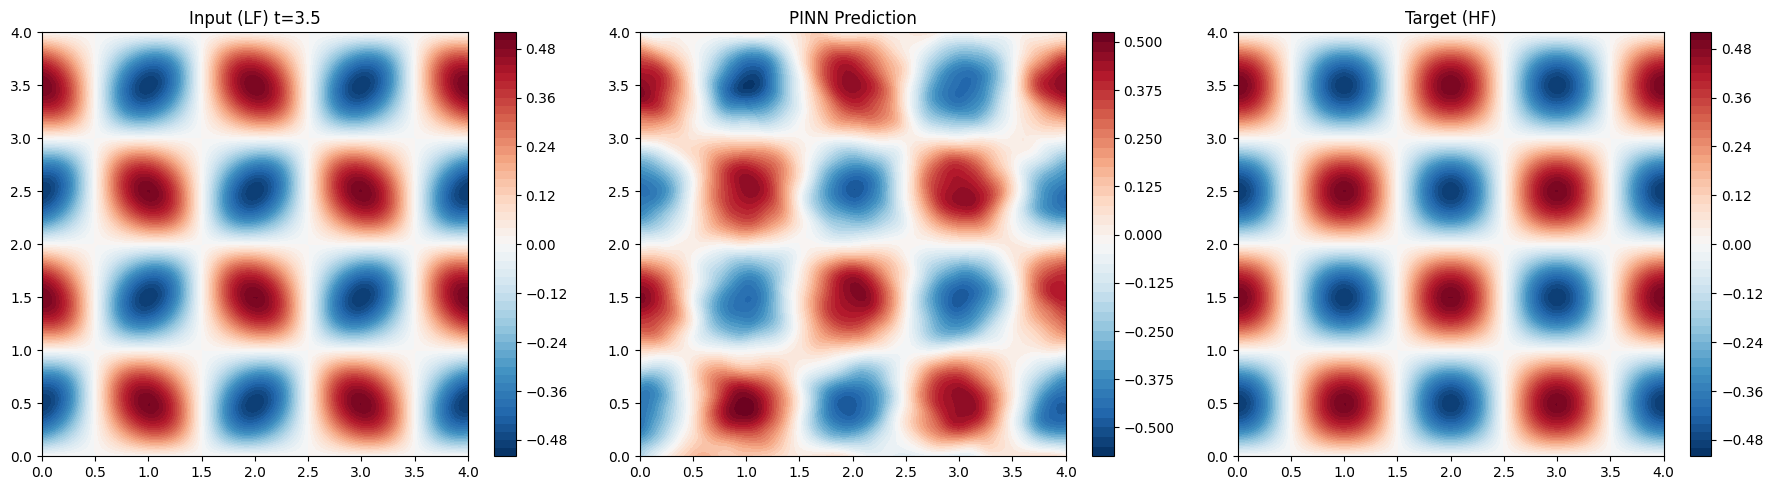

MSE (LF vs HF): 0.000304
MSE (PINN vs HF): 0.001454
개선율: -378.04%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# [추가] GPU 메모리 정리 함수
def clear_memory():
    torch.cuda.empty_cache()

# ==========================================
# 1. 물리 식 정의 (정규화 및 체인 룰 반영)
# ==========================================
def get_pde_loss(model, x, y, t, nu, L=4.0, T=10.0):
    out = model(x, y, t)
    u, v, p = out[:, 0:1], out[:, 1:2], out[:, 2:3]

    def grad(outputs, inputs):
        return torch.autograd.grad(outputs, inputs, torch.ones_like(outputs), create_graph=True)[0]

    u_t = grad(u, t) / T
    v_t = grad(v, t) / T

    u_x_raw, u_y_raw = grad(u, x), grad(u, y)
    v_x_raw, v_y_raw = grad(v, x), grad(v, y)
    p_x_raw, p_y_raw = grad(p, x), grad(p, y)

    u_x, u_y, v_x, v_y, p_x, p_y = u_x_raw/L, u_y_raw/L, v_x_raw/L, v_y_raw/L, p_x_raw/L, p_y_raw/L
    u_xx, u_yy = grad(u_x_raw, x)/(L**2), grad(u_y_raw, y)/(L**2)
    v_xx, v_yy = grad(v_x_raw, x)/(L**2), grad(v_y_raw, y)/(L**2)

    f_mass = u_x + v_y
    f_u = u_t + (u*u_x + v*u_y) + p_x - nu*(u_xx + u_yy)
    f_v = v_t + (u*v_x + v*v_y) + p_y - nu*(v_xx + v_yy)

    return torch.mean(f_mass**2), torch.mean(f_u**2 + f_v**2)

# ==========================================
# 2. 메인 학습 준비 (메모리에 맞게 샘플링 조정)
# ==========================================
clear_memory()
model = PINN().to(device)
model.load_state_dict(torch.load("warmup_model.pth"))

# [메모리 최적화] 지점 수를 약 3.5만 개 수준으로 조정 (GPU 15GB 기준 안전권)
N_rand = 20000
x_rand = torch.rand(N_rand, 1, device=device).requires_grad_(True)
y_rand = torch.rand(N_rand, 1, device=device).requires_grad_(True)
t_rand = torch.rand(N_rand, 1, device=device).requires_grad_(True)

# 그리드 밀도 소폭 조정 (15x35x35 = 18,375개)
t_g = torch.linspace(0, 1, 15, device=device)
x_g = torch.linspace(0, 1, 35, device=device)
y_g = torch.linspace(0, 1, 35, device=device)
T_mesh, X_mesh, Y_mesh = torch.meshgrid(t_g, x_g, y_g, indexing='ij')

x_p = torch.cat([x_rand, X_mesh.reshape(-1, 1)], dim=0).requires_grad_(True)
y_p = torch.cat([y_rand, Y_mesh.reshape(-1, 1)], dim=0).requires_grad_(True)
t_p = torch.cat([t_rand, T_mesh.reshape(-1, 1)], dim=0).requires_grad_(True)

print(f"Total Physics Points: {x_p.shape[0]}")

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ==========================================
# 3. Phase 1: Adam 학습
# ==========================================
print("\n--- Phase 1: PINN Denoising Start ---")
start_time = time.time()

for epoch in range(5001):
    optimizer.zero_grad()

    # 1. Data Loss 계산 (LF 데이터와의 차이)
    out = model(x_train, y_train, t_train)
    l_data = torch.mean((out[:,0:1]-u_train)**2 + (out[:,1:2]-v_train)**2 + (out[:,2:3]-p_train)**2)

    # 2. PDE Loss 계산 (Mass, Momentum)
    l_mass, l_mom = get_pde_loss(model, x_p, y_p, t_p, nu_val)

    # 3. 가중치 적용 및 전체 Loss 계산
    # 데이터 비중 강화 (10.0), 물리 비중 조절 (0.01까지 서서히 증가)
    pde_w = min(0.01 * (epoch/2500), 0.01)
    total_loss = 10.0 * l_data + pde_w * (l_mass + l_mom)

    total_loss.backward()
    optimizer.step()

    # 500 에포크마다 상세 로그 출력
    if epoch % 500 == 0:
        elapsed = time.time() - start_time
        print(f"Ep {epoch:4d} | Total Loss: {total_loss.item():.6f} | Time: {elapsed:.1f}s")
        print(f"       > [Data Loss]     : {l_data.item():.8f}")
        print(f"       > [Mass Loss]     : {l_mass.item():.8f}")
        print(f"       > [Momentum Loss] : {l_mom.item():.8f}")
        print(f"       > [PDE Weight]    : {pde_w:.4f}")
        print("-" * 50)

print("Phase 1 Training Complete.")
# ==========================================
# 4. Phase 2: L-BFGS 정밀화
# ==========================================
print("\n--- Phase 2: L-BFGS Refinement ---")
# L-BFGS는 메모리를 많이 소모하므로 history_size를 줄임
lbfgs = optim.LBFGS(model.parameters(), max_iter=800, history_size=50, line_search_fn="strong_wolfe")

def closure():
    lbfgs.zero_grad()
    out = model(x_train, y_train, t_train)
    ld = torch.mean((out[:,0:1]-u_train)**2 + (out[:,1:2]-v_train)**2 + (out[:,2:3]-p_train)**2)
    lm, lmo = get_pde_loss(model, x_p, y_p, t_p, nu_val)
    loss = 10 * ld + 0.01 * (lm + lmo)
    if loss.requires_grad: loss.backward()
    return loss

lbfgs.step(closure)
clear_memory()

# ==========================================
# 5. 최종 결과 시각화
# ==========================================
test_t = 3.5
X_g, Y_g, u_lf, _, _, u_hf, _, _ = generator.get_data_at_t(GRID, GRID, test_t)

x_in = torch.tensor(X_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
y_in = torch.tensor(Y_g.flatten()/L_val, dtype=torch.float32).view(-1, 1).to(device)
t_in = torch.tensor(np.full(x_in.shape, test_t/10.0), dtype=torch.float32).view(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_in, y_in, t_in)[:, 0].cpu().numpy().reshape(GRID, GRID)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1); plt.contourf(X_g, Y_g, u_lf, levels=50, cmap='RdBu_r'); plt.title(f"Input (LF) t={test_t}"); plt.colorbar()
plt.subplot(1, 3, 2); plt.contourf(X_g, Y_g, u_pred, levels=50, cmap='RdBu_r'); plt.title("PINN Prediction"); plt.colorbar()
plt.subplot(1, 3, 3); plt.contourf(X_g, Y_g, u_hf, levels=50, cmap='RdBu_r'); plt.title("Target (HF)"); plt.colorbar()
plt.tight_layout(); plt.show()

mse_lf = np.mean((u_lf - u_hf)**2)
mse_pinn = np.mean((u_pred - u_hf)**2)
print(f"MSE (LF vs HF): {mse_lf:.6f}")
print(f"MSE (PINN vs HF): {mse_pinn:.6f}")
print(f"개선율: {(mse_lf - mse_pinn)/mse_lf * 100:.2f}%")